In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.aqua import QuantumInstance
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, IQPE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP

# chemistry components
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.aqua.algorithms import VQAlgorithm, VQE, MinimumEigensolver
from qiskit.chemistry.transformations import FermionicTransformation
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.chemistry.algorithms.pes_samplers.bopes_sampler import BOPESSampler
from qiskit.chemistry.drivers.molecule import Molecule
from qiskit.chemistry.algorithms.pes_samplers.extrapolator import *

import warnings
warnings.simplefilter('ignore', np.RankWarning)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')
/opt/conda/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
ft = FermionicTransformation()
driver = PySCFDriver()
solver = VQE(quantum_instance=
             QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))
me_gsc = GroundStateEigensolver(ft, solver)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm 

In [4]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[stretch1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

In [5]:
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.3])]


In [6]:
mol.perturbations = [0.2]
print(mol.geometry)

mol.perturbations = [0.6]
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.5])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.8999999999999999])]


In [7]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[distance1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

# Specify degree of freedom (points of interest)
points = np.linspace(0.25, 2, 30)
results_full = {} # full dictionary of results for each condition
results = {} # dictionary of (point,energy) results for each condition
conditions = {False: 'no bootstrapping', True: 'bootstrapping'}


for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(
        gss=me_gsc
        ,bootstrap=value
        ,num_bootstrap=None
        ,extrapolator=None)
    # execute
    res = bs.sample(driver,points)
    results_full[f'{bootstrap}'] =  res.raw_results
    results[f'points_{bootstrap}'] = res.points
    results[f'energies_{bootstrap}'] = res.energies

/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/opt/conda/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:394: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  task_args=(threshold,), num_processes=aqua_globals.num_processes)


In [8]:
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(ft, solver_numpy)
bs_classical = BOPESSampler(
               gss=me_gsc_numpy
               ,bootstrap=False
               ,num_bootstrap=None
               ,extrapolator=None)
# execute
res_np = bs_classical.sample(driver, points)
results_full['np'] =  res_np.raw_results
results['points_np'] = res_np.points
results['energies_np'] = res_np.energies

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


Text(0, 0.5, 'Energy')

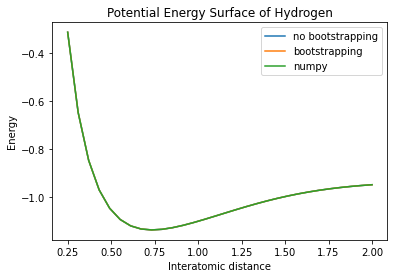

In [10]:
fig = plt.figure()
for value, bootstrap in conditions.items():
    plt.plot(results[f'points_{bootstrap}'], results[f'energies_{bootstrap}'], label = f'{bootstrap}')
plt.plot(results['points_np'], results['energies_np'], label = 'numpy')
plt.legend()
plt.title('Potential Energy Surface of Hydrogen')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')